## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline


# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

2021-11-22 21:25:12.516108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 21:25:12.516149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.gradient_descent_v2.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=0.95),
                 tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 tensorflow.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3, 5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
bat

2021-11-22 21:26:44.071656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-22 21:26:44.071771: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 21:26:44.071820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (11402.pyspark3): /proc/driver/nvidia/version does not exist
2021-11-22 21:26:44.072376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 21:26:44.781558: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 ex

Epoch 1/25
49/49 [==============================] - 3s 57ms/step - loss: 2.2121 - accuracy: 0.2665 - val_loss: 2.1534 - val_accuracy: 0.2009
Epoch 2/25
49/49 [==============================] - 3s 58ms/step - loss: 1.7626 - accuracy: 0.3857 - val_loss: 1.9762 - val_accuracy: 0.2971
Epoch 3/25
49/49 [==============================] - 2s 47ms/step - loss: 1.6314 - accuracy: 0.4294 - val_loss: 1.8318 - val_accuracy: 0.3758
Epoch 4/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5568 - accuracy: 0.4562 - val_loss: 1.7203 - val_accuracy: 0.4072
Epoch 5/25
49/49 [==============================] - 2s 45ms/step - loss: 1.5010 - accuracy: 0.4763 - val_loss: 1.6410 - val_accuracy: 0.4316
Epoch 6/25
49/49 [==============================] - 2s 46ms/step - loss: 1.4569 - accuracy: 0.4931 - val_loss: 1.5846 - val_accuracy: 0.4468
Epoch 7/25
49/49 [==============================] - 2s 49ms/step - loss: 1.4149 - accuracy: 0.5071 - val_loss: 1.5692 - val_accuracy: 0.4464
Epoch 8/25
49

2021-11-22 21:28:02.080438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 4s 58ms/step - loss: 2.1696 - accuracy: 0.2767 - val_loss: 2.1428 - val_accuracy: 0.1906
Epoch 2/25
49/49 [==============================] - 3s 56ms/step - loss: 1.7418 - accuracy: 0.3953 - val_loss: 1.9665 - val_accuracy: 0.2815
Epoch 3/25
49/49 [==============================] - 3s 67ms/step - loss: 1.6180 - accuracy: 0.4366 - val_loss: 1.8348 - val_accuracy: 0.3500
Epoch 4/25
49/49 [==============================] - 2s 44ms/step - loss: 1.5442 - accuracy: 0.4627 - val_loss: 1.7560 - val_accuracy: 0.3829
Epoch 5/25
49/49 [==============================] - 2s 42ms/step - loss: 1.4891 - accuracy: 0.4826 - val_loss: 1.6591 - val_accuracy: 0.4192
Epoch 6/25
49/49 [==============================] - 2s 46ms/step - loss: 1.4430 - accuracy: 0.4988 - val_loss: 1.5886 - val_accuracy: 0.4472
Epoch 7/25
49/49 [==============================] - 2s 44ms/step - loss: 1.4030 - accuracy: 0.5112 - val_loss: 1.5594 - val_accuracy: 0.4554
Epoch 8/25
49

2021-11-22 21:29:06.417070: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 3s 57ms/step - loss: 2.2181 - accuracy: 0.2659 - val_loss: 2.1326 - val_accuracy: 0.1738
Epoch 2/25
49/49 [==============================] - 2s 49ms/step - loss: 1.7543 - accuracy: 0.3885 - val_loss: 1.9779 - val_accuracy: 0.2811
Epoch 3/25
49/49 [==============================] - 2s 50ms/step - loss: 1.6326 - accuracy: 0.4318 - val_loss: 1.8378 - val_accuracy: 0.3442
Epoch 4/25
49/49 [==============================] - 2s 48ms/step - loss: 1.5571 - accuracy: 0.4565 - val_loss: 1.7270 - val_accuracy: 0.3936
Epoch 5/25
49/49 [==============================] - 2s 51ms/step - loss: 1.5000 - accuracy: 0.4761 - val_loss: 1.6634 - val_accuracy: 0.4146
Epoch 6/25
49/49 [==============================] - 3s 54ms/step - loss: 1.4548 - accuracy: 0.4917 - val_loss: 1.5954 - val_accuracy: 0.4390
Epoch 7/25
49/49 [==============================] - 3s 54ms/step - loss: 1.4149 - accuracy: 0.5073 - val_loss: 1.5561 - val_accuracy: 0.4502
Epoch 8/25
49

2021-11-22 21:30:12.091205: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 3s 46ms/step - loss: 2.2299 - accuracy: 0.2700 - val_loss: 2.1420 - val_accuracy: 0.1799
Epoch 2/25
49/49 [==============================] - 2s 41ms/step - loss: 1.7622 - accuracy: 0.3875 - val_loss: 1.9844 - val_accuracy: 0.2788
Epoch 3/25
49/49 [==============================] - 2s 42ms/step - loss: 1.6306 - accuracy: 0.4317 - val_loss: 1.8437 - val_accuracy: 0.3433
Epoch 4/25
49/49 [==============================] - 2s 41ms/step - loss: 1.5517 - accuracy: 0.4603 - val_loss: 1.7282 - val_accuracy: 0.4046
Epoch 5/25
49/49 [==============================] - 2s 41ms/step - loss: 1.4932 - accuracy: 0.4806 - val_loss: 1.6450 - val_accuracy: 0.4309
Epoch 6/25
49/49 [==============================] - 2s 41ms/step - loss: 1.4473 - accuracy: 0.4952 - val_loss: 1.5837 - val_accuracy: 0.4446
Epoch 7/25
49/49 [==============================] - 2s 49ms/step - loss: 1.4066 - accuracy: 0.5109 - val_loss: 1.5535 - val_accuracy: 0.4554
Epoch 8/25
49

2021-11-22 21:31:10.314800: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 3s 56ms/step - loss: 2.3615 - accuracy: 0.2335 - val_loss: 2.1490 - val_accuracy: 0.2137
Epoch 2/25
49/49 [==============================] - 2s 41ms/step - loss: 1.8719 - accuracy: 0.3507 - val_loss: 2.0330 - val_accuracy: 0.2759
Epoch 3/25
49/49 [==============================] - 2s 41ms/step - loss: 1.7315 - accuracy: 0.3966 - val_loss: 1.9216 - val_accuracy: 0.3212
Epoch 4/25
49/49 [==============================] - 2s 42ms/step - loss: 1.6537 - accuracy: 0.4221 - val_loss: 1.7970 - val_accuracy: 0.3671
Epoch 5/25
49/49 [==============================] - 2s 41ms/step - loss: 1.5989 - accuracy: 0.4403 - val_loss: 1.7268 - val_accuracy: 0.3903
Epoch 6/25
49/49 [==============================] - 2s 42ms/step - loss: 1.5546 - accuracy: 0.4567 - val_loss: 1.6733 - val_accuracy: 0.4067
Epoch 7/25
49/49 [==============================] - 2s 41ms/step - loss: 1.5198 - accuracy: 0.4684 - val_loss: 1.6271 - val_accuracy: 0.4262
Epoch 8/25
49

49/49 [==============================] - 2s 47ms/step - loss: 1.1905 - accuracy: 0.5908 - val_loss: 1.4866 - val_accuracy: 0.4839
Epoch 24/25
49/49 [==============================] - 2s 47ms/step - loss: 1.1761 - accuracy: 0.5954 - val_loss: 1.4841 - val_accuracy: 0.4860
Epoch 25/25
49/49 [==============================] - 2s 51ms/step - loss: 1.1613 - accuracy: 0.6018 - val_loss: 1.4767 - val_accuracy: 0.4834
Numbers of exp: 6, reduce_factor: 0.10, reduce_patient: 3
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________

49/49 [==============================] - 2s 46ms/step - loss: 1.4398 - accuracy: 0.4968 - val_loss: 1.5692 - val_accuracy: 0.4524
Epoch 11/25
49/49 [==============================] - 2s 48ms/step - loss: 1.4149 - accuracy: 0.5071 - val_loss: 1.5607 - val_accuracy: 0.4567
Epoch 12/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3939 - accuracy: 0.5129 - val_loss: 1.5546 - val_accuracy: 0.4595
Epoch 13/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3735 - accuracy: 0.5213 - val_loss: 1.5443 - val_accuracy: 0.4663
Epoch 14/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3550 - accuracy: 0.5273 - val_loss: 1.5327 - val_accuracy: 0.4717
Epoch 15/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3347 - accuracy: 0.5365 - val_loss: 1.5316 - val_accuracy: 0.4708
Epoch 16/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3178 - accuracy: 0.5410 - val_loss: 1.5176 - val_accuracy: 0.4751
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 4s 64ms/step - loss: 1.7576 - accuracy: 0.3865 - val_loss: 2.9629 - val_accuracy: 0.2060
Epoch 2/25
49/49 [==============================] - 3s 57ms/step - loss: 1.4776 - accuracy: 0.4788 - val_loss: 2.0005 - val_accuracy: 0.2888
Epoch 3/25
49/49 [==============================] - 3s 53ms/step - loss: 1.3842 - accuracy: 0.5135 - val_loss: 1.8179 - val_accuracy: 0.3639
Epoch 4/25
49/49 [==============================] - 3s 54ms/step - loss: 1.3101 - accuracy: 0.5396 - val_loss: 1.7393 - val_accuracy: 0.3805
Epoch 5/25
49/49 [==============================] - 3s 53ms/step - loss: 1.2476 - accuracy: 0.5593 - val_loss: 1.8590 - val_accuracy: 0.3817
Epoch 6/25
49/49 [==============================] - 3s 53ms/step - loss: 1.1888 - accuracy: 0.5827 - val_loss: 1.7226 - val_accuracy: 0.3897
Epoch 7/25
49/49 [==============================] - 3s 52ms/step - loss: 1.1354 - accuracy: 0.6005 - val_loss: 1.9845 - val_accuracy: 0.3362
Epoch 8/25
49

49/49 [==============================] - 3s 52ms/step - loss: 0.8517 - accuracy: 0.6993 - val_loss: 1.6435 - val_accuracy: 0.4799
Epoch 21/25
49/49 [==============================] - 2s 50ms/step - loss: 0.8127 - accuracy: 0.7137 - val_loss: 1.5976 - val_accuracy: 0.4990
Epoch 22/25
49/49 [==============================] - 3s 53ms/step - loss: 0.7804 - accuracy: 0.7273 - val_loss: 1.5795 - val_accuracy: 0.4884
Epoch 23/25
49/49 [==============================] - 2s 50ms/step - loss: 0.7482 - accuracy: 0.7381 - val_loss: 1.6115 - val_accuracy: 0.4891
Epoch 24/25
49/49 [==============================] - 3s 52ms/step - loss: 0.7196 - accuracy: 0.7497 - val_loss: 1.6609 - val_accuracy: 0.4868

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009227448242017999.
Epoch 25/25
49/49 [==============================] - 3s 57ms/step - loss: 0.6843 - accuracy: 0.7627 - val_loss: 1.8763 - val_accuracy: 0.4612
Numbers of exp: 11, reduce_factor: 0.99, reduce_patient: 10
Model: "model_11"
_

Epoch 6/25
49/49 [==============================] - 2s 50ms/step - loss: 1.3181 - accuracy: 0.5319 - val_loss: 1.5527 - val_accuracy: 0.4530
Epoch 7/25
49/49 [==============================] - 2s 44ms/step - loss: 1.2754 - accuracy: 0.5443 - val_loss: 1.5180 - val_accuracy: 0.4615
Epoch 8/25
49/49 [==============================] - 3s 59ms/step - loss: 1.2304 - accuracy: 0.5621 - val_loss: 1.4521 - val_accuracy: 0.4836
Epoch 9/25
49/49 [==============================] - 4s 73ms/step - loss: 1.1925 - accuracy: 0.5747 - val_loss: 1.4904 - val_accuracy: 0.4723
Epoch 10/25
49/49 [==============================] - 4s 75ms/step - loss: 1.1582 - accuracy: 0.5894 - val_loss: 1.4317 - val_accuracy: 0.4904
Epoch 11/25
49/49 [==============================] - 3s 57ms/step - loss: 1.1259 - accuracy: 0.6002 - val_loss: 1.5194 - val_accuracy: 0.4670
Epoch 12/25
49/49 [==============================] - 2s 43ms/step - loss: 1.0944 - accuracy: 0.6118 - val_loss: 1.5540 - val_accuracy: 0.4719
Epoch 13/2

49/49 [==============================] - 2s 49ms/step - loss: 0.6595 - accuracy: 0.8011 - val_loss: 1.4096 - val_accuracy: 0.5227
Numbers of exp: 14, reduce_factor: 0.50, reduce_patient: 10
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_42 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________


49/49 [==============================] - 2s 45ms/step - loss: 1.1912 - accuracy: 0.5960 - val_loss: 1.4731 - val_accuracy: 0.4802
Epoch 13/25
49/49 [==============================] - 2s 45ms/step - loss: 1.1701 - accuracy: 0.6028 - val_loss: 1.4617 - val_accuracy: 0.4847
Epoch 14/25
49/49 [==============================] - 2s 46ms/step - loss: 1.1518 - accuracy: 0.6106 - val_loss: 1.4693 - val_accuracy: 0.4862
Epoch 15/25
49/49 [==============================] - 2s 48ms/step - loss: 1.1322 - accuracy: 0.6196 - val_loss: 1.4573 - val_accuracy: 0.4831
Epoch 16/25
49/49 [==============================] - 2s 48ms/step - loss: 1.1122 - accuracy: 0.6270 - val_loss: 1.4467 - val_accuracy: 0.4917
Epoch 17/25
49/49 [==============================] - 3s 54ms/step - loss: 1.0953 - accuracy: 0.6332 - val_loss: 1.4604 - val_accuracy: 0.4880
Epoch 18/25
49/49 [==============================] - 3s 55ms/step - loss: 1.0778 - accuracy: 0.6395 - val_loss: 1.4463 - val_accuracy: 0.4911
Epoch 19/25
49/49 

Epoch 1/25
49/49 [==============================] - 4s 56ms/step - loss: 2.4114 - accuracy: 0.2161 - val_loss: 2.1852 - val_accuracy: 0.2167
Epoch 2/25
49/49 [==============================] - 3s 61ms/step - loss: 2.0552 - accuracy: 0.3038 - val_loss: 2.1014 - val_accuracy: 0.2613
Epoch 3/25
49/49 [==============================] - 3s 55ms/step - loss: 1.9481 - accuracy: 0.3314 - val_loss: 2.0271 - val_accuracy: 0.2925
Epoch 4/25
49/49 [==============================] - 2s 49ms/step - loss: 1.8855 - accuracy: 0.3511 - val_loss: 1.9641 - val_accuracy: 0.3128
Epoch 5/25
49/49 [==============================] - 2s 49ms/step - loss: 1.8398 - accuracy: 0.3625 - val_loss: 1.9032 - val_accuracy: 0.3349
Epoch 6/25
49/49 [==============================] - 3s 60ms/step - loss: 1.8062 - accuracy: 0.3760 - val_loss: 1.8553 - val_accuracy: 0.3497
Epoch 7/25
49/49 [==============================] - 3s 52ms/step - loss: 1.7782 - accuracy: 0.3835 - val_loss: 1.8246 - val_accuracy: 0.3596
Epoch 8/25
49

49/49 [==============================] - 3s 55ms/step - loss: 0.7475 - accuracy: 0.7395 - val_loss: 1.7593 - val_accuracy: 0.4297
Epoch 22/25
49/49 [==============================] - 3s 55ms/step - loss: 0.7243 - accuracy: 0.7473 - val_loss: 2.1454 - val_accuracy: 0.3966

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 23/25
49/49 [==============================] - 3s 57ms/step - loss: 0.6950 - accuracy: 0.7576 - val_loss: 2.2955 - val_accuracy: 0.3572
Epoch 24/25
49/49 [==============================] - 3s 53ms/step - loss: 0.6731 - accuracy: 0.7642 - val_loss: 1.8611 - val_accuracy: 0.4441
Epoch 25/25
49/49 [==============================] - 3s 55ms/step - loss: 0.6513 - accuracy: 0.7757 - val_loss: 2.1380 - val_accuracy: 0.3990

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Numbers of exp: 19, reduce_factor: 0.99, reduce_patient: 5
Model: "model_19"
_______________________________________________________________

49/49 [==============================] - 3s 65ms/step - loss: 1.2861 - accuracy: 0.5459 - val_loss: 1.7904 - val_accuracy: 0.3720
Epoch 6/25
49/49 [==============================] - 3s 64ms/step - loss: 1.2447 - accuracy: 0.5610 - val_loss: 2.0079 - val_accuracy: 0.3432
Epoch 7/25
49/49 [==============================] - 3s 56ms/step - loss: 1.1966 - accuracy: 0.5786 - val_loss: 1.7526 - val_accuracy: 0.3916
Epoch 8/25
49/49 [==============================] - 3s 59ms/step - loss: 1.1561 - accuracy: 0.5905 - val_loss: 1.8469 - val_accuracy: 0.3569
Epoch 9/25
49/49 [==============================] - 3s 58ms/step - loss: 1.1095 - accuracy: 0.6076 - val_loss: 2.0606 - val_accuracy: 0.3244
Epoch 10/25
49/49 [==============================] - 3s 55ms/step - loss: 1.0796 - accuracy: 0.6192 - val_loss: 2.0792 - val_accuracy: 0.3354
Epoch 11/25
49/49 [==============================] - 3s 61ms/step - loss: 1.0380 - accuracy: 0.6342 - val_loss: 2.0618 - val_accuracy: 0.3655
Epoch 12/25
49/49 [===

49/49 [==============================] - 3s 55ms/step - loss: 0.5777 - accuracy: 0.8213 - val_loss: 1.4083 - val_accuracy: 0.5405
Epoch 25/25
49/49 [==============================] - 2s 48ms/step - loss: 0.5704 - accuracy: 0.8227 - val_loss: 1.4073 - val_accuracy: 0.5430
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_66 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________

Epoch 10/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5793 - accuracy: 0.4536 - val_loss: 1.6604 - val_accuracy: 0.4188
Epoch 11/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5529 - accuracy: 0.4630 - val_loss: 1.6477 - val_accuracy: 0.4250
Epoch 12/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5281 - accuracy: 0.4713 - val_loss: 1.6419 - val_accuracy: 0.4251
Epoch 13/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5050 - accuracy: 0.4803 - val_loss: 1.6291 - val_accuracy: 0.4311
Epoch 14/25
49/49 [==============================] - 2s 49ms/step - loss: 1.4843 - accuracy: 0.4881 - val_loss: 1.6191 - val_accuracy: 0.4349
Epoch 15/25
49/49 [==============================] - 2s 49ms/step - loss: 1.4653 - accuracy: 0.4935 - val_loss: 1.6058 - val_accuracy: 0.4402
Epoch 16/25
49/49 [==============================] - 2s 50ms/step - loss: 1.4469 - accuracy: 0.5005 - val_loss: 1.6054 - val_accuracy: 0.4426
Epoch 

Epoch 1/25
49/49 [==============================] - 4s 58ms/step - loss: 2.4492 - accuracy: 0.2169 - val_loss: 2.2145 - val_accuracy: 0.1963
Epoch 2/25
49/49 [==============================] - 3s 55ms/step - loss: 2.0896 - accuracy: 0.3012 - val_loss: 2.0901 - val_accuracy: 0.2497
Epoch 3/25
49/49 [==============================] - 2s 50ms/step - loss: 1.9399 - accuracy: 0.3404 - val_loss: 1.9839 - val_accuracy: 0.3021
Epoch 4/25
49/49 [==============================] - 2s 50ms/step - loss: 1.8423 - accuracy: 0.3661 - val_loss: 1.8925 - val_accuracy: 0.3352
Epoch 5/25
49/49 [==============================] - 2s 50ms/step - loss: 1.7717 - accuracy: 0.3889 - val_loss: 1.8183 - val_accuracy: 0.3671
Epoch 6/25
49/49 [==============================] - 2s 50ms/step - loss: 1.7173 - accuracy: 0.4069 - val_loss: 1.7665 - val_accuracy: 0.3792
Epoch 7/25
49/49 [==============================] - 2s 49ms/step - loss: 1.6715 - accuracy: 0.4210 - val_loss: 1.7378 - val_accuracy: 0.3924
Epoch 8/25
49

49/49 [==============================] - 2s 49ms/step - loss: 1.3282 - accuracy: 0.5422 - val_loss: 1.5627 - val_accuracy: 0.4602
Epoch 24/25
49/49 [==============================] - 2s 50ms/step - loss: 1.3158 - accuracy: 0.5477 - val_loss: 1.5580 - val_accuracy: 0.4608
Epoch 25/25
49/49 [==============================] - 2s 49ms/step - loss: 1.3018 - accuracy: 0.5528 - val_loss: 1.5483 - val_accuracy: 0.4630


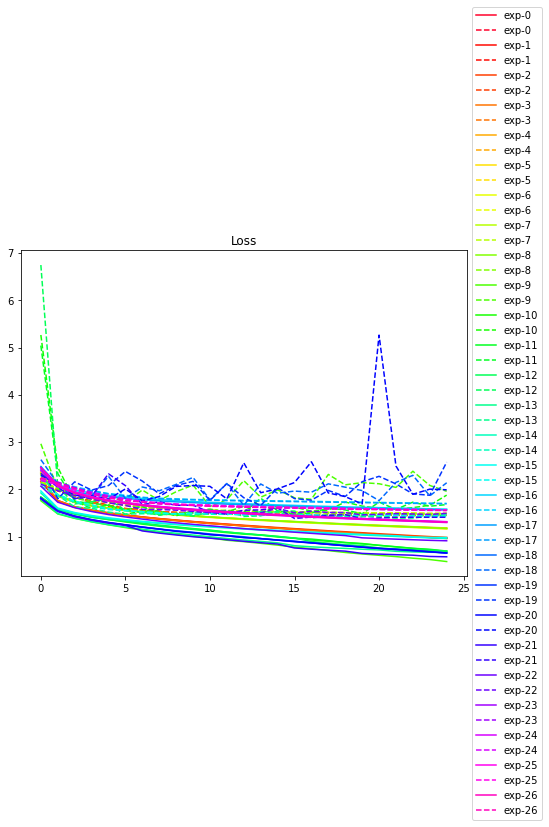

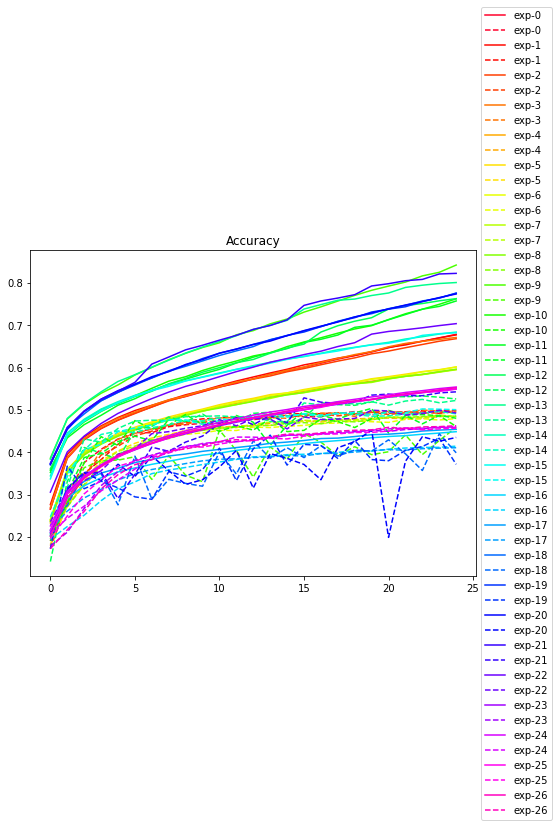

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()